
[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


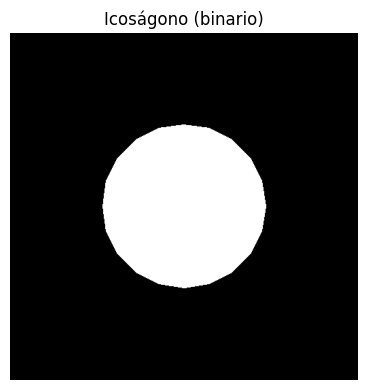

In [15]:
# ============================================
# Laboratorio de Filtrado - Icoságono Regular
# Autor: Felipe Valencia
# Estructura: carga/generación -> binarización -> morfología -> métricas -> Excel -> cmaps
# ============================================

%pip install xlsxwriter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, os

# ---------- util ----------
OUTDIR = "resultados"
os.makedirs(OUTDIR, exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()

# ---------- 1) Generar Icoságono (binario) ----------
def crear_icosagono(lados=20, radio=120, img_size=512, fill=255):
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx, cy = img_size//2, img_size//2
    ang = 2*np.pi/lados
    vertices = [(int(cx + radio*np.cos(i*ang)),
                 int(cy + radio*np.sin(i*ang))) for i in range(lados)]
    pts = np.array(vertices, np.int32).reshape((-1,1,2))
    cv2.fillPoly(img, [pts], fill)
    return img, np.array(vertices, dtype=np.float32)

mask_bin, vertices = crear_icosagono()
plt.figure(figsize=(4,4))
plt.imshow(mask_bin, cmap="gray")
plt.title("Icoságono (binario)")
plt.axis("off")
savefig(f"{OUTDIR}/00_icosagono.png")

# (Opcional) Si quieres partir de imagen externa:
# gray = cv2.imread('/content/radiografia.jpg', cv2.IMREAD_GRAYSCALE)









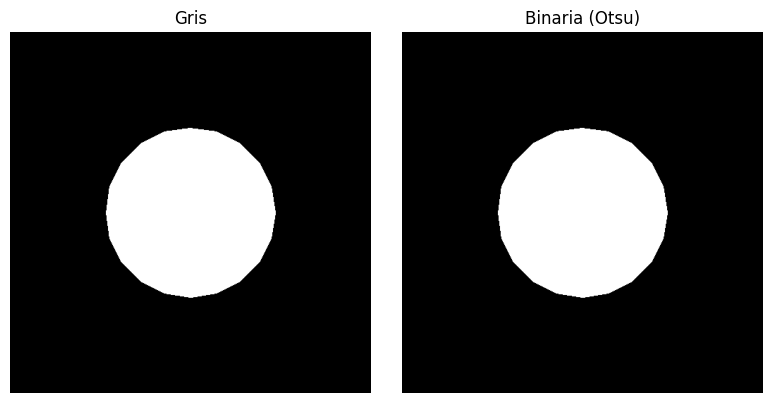

In [16]:
# ---------- 2) Preprocesamiento ----------
# Pasamos la binaria a "gris" por compatibilidad de pipeline
gray = mask_bin.copy()

# Umbral (Otsu) para asegurar binarización robusta
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(gray, cmap='gray'); plt.title("Gris"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(binary, cmap='gray'); plt.title("Binaria (Otsu)"); plt.axis("off")
savefig(f"{OUTDIR}/01_preprocesamiento.png")


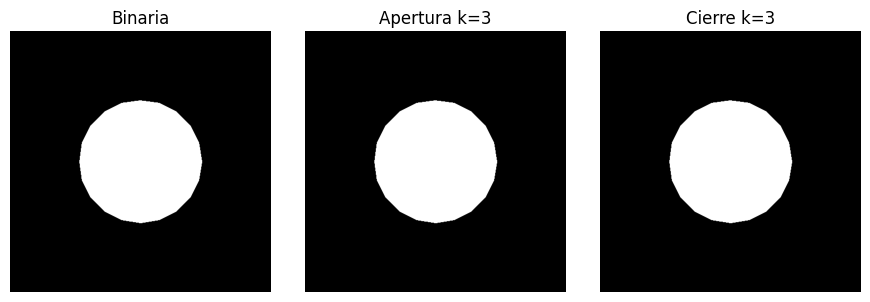

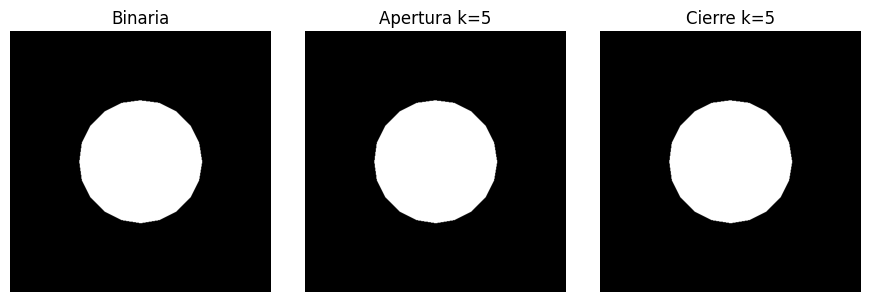

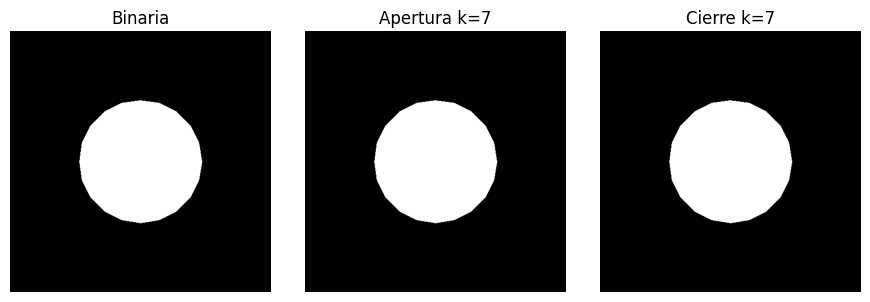

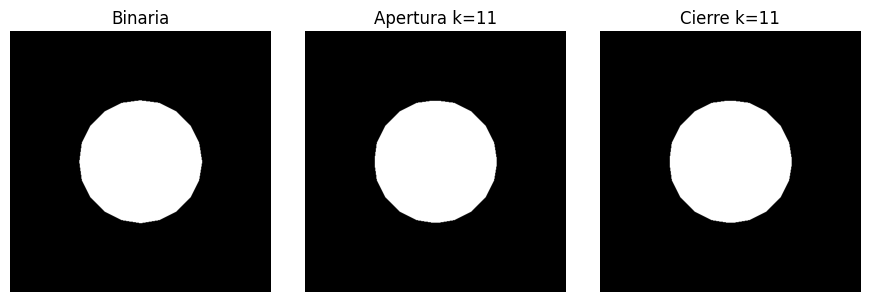

In [17]:
# ---------- 3) Morfología con diferentes kernels ----------
kernel_sizes = [3,5,7,11]  # <-- cambia y compara
results_summary = []
rows_objects = []

def features_from_contour(cnt, mask_shape):
    area = cv2.contourArea(cnt)
    perim = cv2.arcLength(cnt, True)
    circ = (4*np.pi*area)/(perim**2) if perim>0 else 0

    x,y,w,h = cv2.boundingRect(cnt)
    aspect = (w/h) if h>0 else 0
    extent = area/(w*h) if w*h>0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area/hull_area if hull_area>0 else 0

    # vértices aproximados (para ver “cuántos lados” detecta)
    eps = 0.01*perim if perim>0 else 1.0
    approx = cv2.approxPolyDP(cnt, eps, True)
    n_vertices = len(approx)

    return {
        "area": area, "perimetro": perim, "circularidad": circ,
        "aspect_ratio": aspect, "extent": extent, "solidez": solidity,
        "n_vertices_aprox": n_vertices, "bbox_x": x, "bbox_y": y, "bbox_w": w, "bbox_h": h
    }

for k in kernel_sizes:
    K = cv2.getStructuringElement(cv2.MORPH_RECT, (k,k))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, K, iterations=1)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, K, iterations=1)

    # guardar imágenes
    cv2.imwrite(f"{OUTDIR}/morph_open_k{k}.png", opened)
    cv2.imwrite(f"{OUTDIR}/morph_close_k{k}.png", closed)

    # contornos
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # imagen de visualización
    vis = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(vis, cnts, -1, (0,255,0), 2)
    cv2.imwrite(f"{OUTDIR}/contours_k{k}.png", vis)

    # métricas por contorno
    for idx, c in enumerate(cnts):
        f = features_from_contour(c, closed.shape)
        rows_objects.append({
            "kernel": k, "obj_id": idx, **f
        })

    # resumen (tomamos el contorno mayor)
    if len(cnts)>0:
        areas = [cv2.contourArea(c) for c in cnts]
        i_max = int(np.argmax(areas))
        fmax = features_from_contour(cnts[i_max], closed.shape)
        results_summary.append({
            "kernel": k, "num_objetos": len(cnts), **fmax
        })

    # panel comparativo
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(binary, cmap='gray'); plt.title("Binaria"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(opened, cmap='gray'); plt.title(f"Apertura k={k}"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(closed, cmap='gray'); plt.title(f"Cierre k={k}"); plt.axis("off")
    savefig(f"{OUTDIR}/panel_k{k}.png")

In [18]:
# ---------- 4) Tablas y Excel ----------
df_resumen = pd.DataFrame(results_summary)
df_objetos = pd.DataFrame(rows_objects)

print("Resumen por kernel:")
display(df_resumen)
print("Objetos por kernel:")
display(df_objetos)

excel_path = f"{OUTDIR}/resultados_medidas.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_resumen.to_excel(writer, index=False, sheet_name="resumen_por_kernel")
    df_objetos.to_excel(writer, index=False, sheet_name="objetos_por_kernel")
print("Guardado:", excel_path)

Resumen por kernel:


,kernel,num_objetos,area,perimetro,circularidad,aspect_ratio,extent,solidez,n_vertices_aprox,bbox_x,bbox_y,bbox_w,bbox_h
0,3,1,44737.0,791.293496,0.897845,1.0,0.770252,0.995882,12,136,136,241,241
1,5,1,44737.0,791.293496,0.897845,1.0,0.770252,0.995882,12,136,136,241,241
2,7,1,44737.0,791.293496,0.897845,1.0,0.770252,0.995882,12,136,136,241,241
3,11,1,44709.0,787.979787,0.904846,1.0,0.782707,0.996434,12,137,137,239,239


Objetos por kernel:


,kernel,obj_id,area,perimetro,circularidad,aspect_ratio,extent,solidez,n_vertices_aprox,bbox_x,bbox_y,bbox_w,bbox_h
0,3,0,44737.0,791.293496,0.897845,1.0,0.770252,0.995882,12,136,136,241,241
1,5,0,44737.0,791.293496,0.897845,1.0,0.770252,0.995882,12,136,136,241,241
2,7,0,44737.0,791.293496,0.897845,1.0,0.770252,0.995882,12,136,136,241,241
3,11,0,44709.0,787.979787,0.904846,1.0,0.782707,0.996434,12,137,137,239,239


Guardado: resultados/resultados_medidas.xlsx


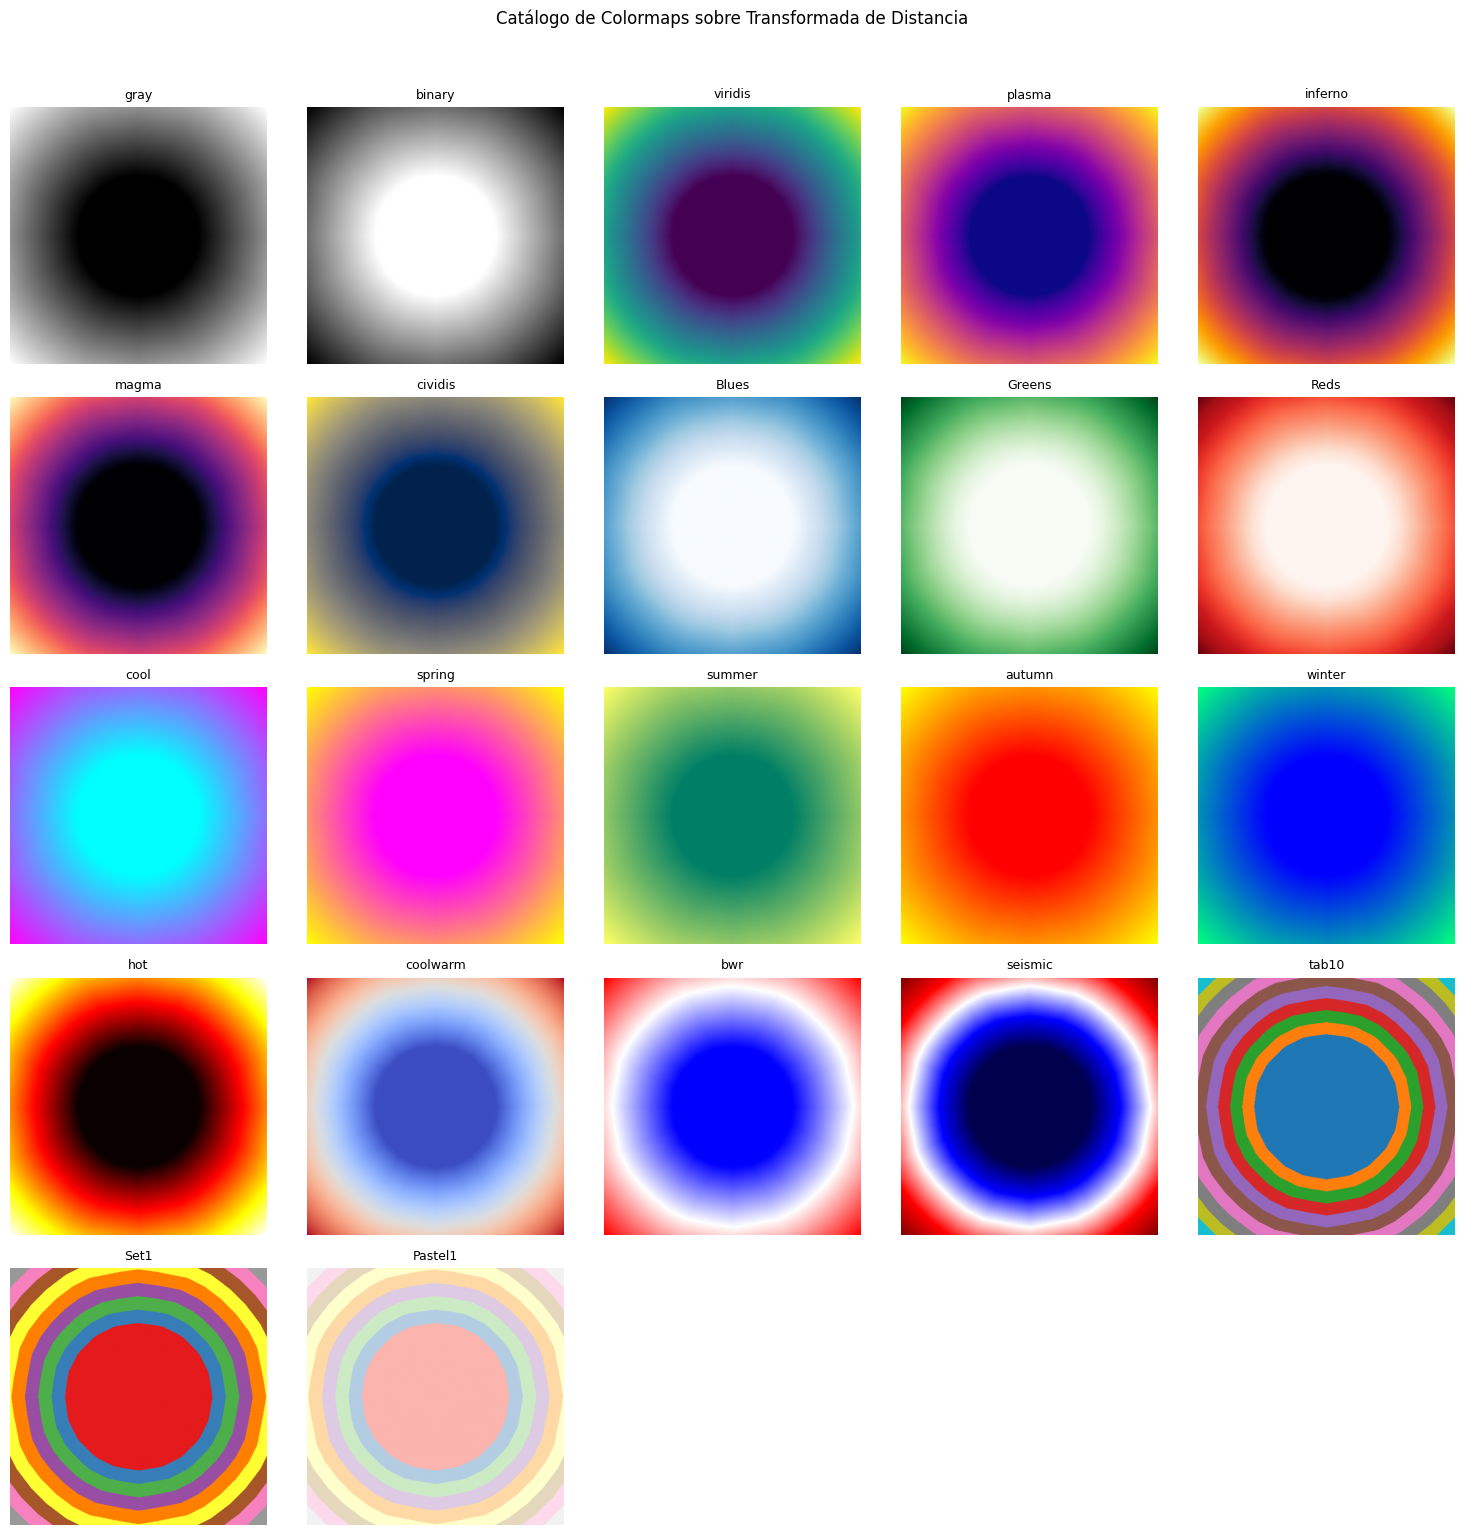

In [19]:
# ---------- 5) Catálogo de Colormaps (útil para visualizar gradientes) ----------
# Para que los colormaps tengan sentido, usamos la Transformada de Distancia sobre la máscara final (k=5 como ejemplo)
K = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
closed_5 = cv2.morphologyEx(cv2.morphologyEx(binary, cv2.MORPH_OPEN, K), cv2.MORPH_CLOSE, K)
# invertimos para que el interior (objeto) cuente distancia al fondo
inv = cv2.bitwise_not(closed_5)
dist = cv2.distanceTransform(inv, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

cmaps = [
    "gray", "binary", "viridis", "plasma", "inferno", "magma", "cividis",
    "Blues", "Greens", "Reds", "cool", "spring", "summer", "autumn", "winter",
    "hot", "coolwarm", "bwr", "seismic", "tab10", "Set1", "Pastel1"
]

n_cols = 5
n_rows = int(np.ceil(len(cmaps)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))
axes = axes.ravel()

for i, cmap in enumerate(cmaps):
    axes[i].imshow(dist, cmap=cmap)
    axes[i].set_title(cmap, fontsize=9)
    axes[i].axis("off")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Catálogo de Colormaps sobre Transformada de Distancia", y=1.02, fontsize=12)
savefig(f"{OUTDIR}/cmaps_catalogo.png")


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


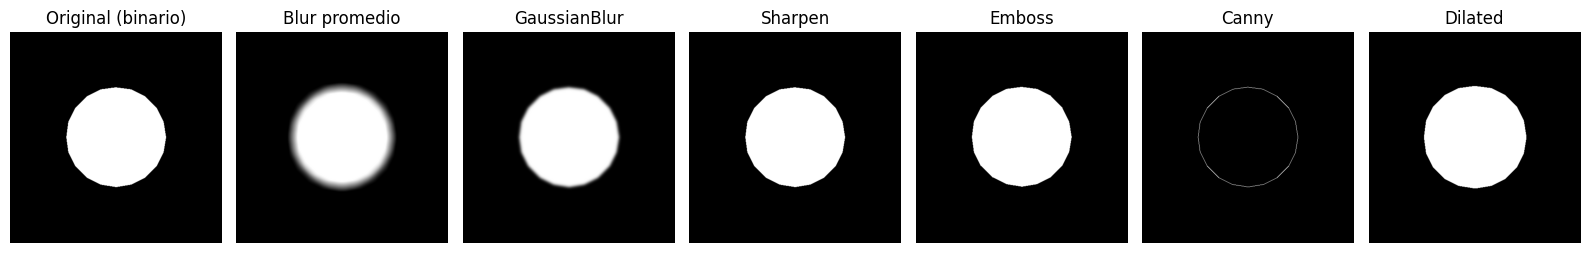

Archivos guardados en: resultados_filters
- 00_icosagono_binario.png
- 01_icosagono_color_bgr.png
- 02_icosagono_gray.png
- binario_blur_avg_k25.png
- binario_canny_30_120.png
- binario_dilate_k7.png
- binario_emboss.png
- binario_gaussian_k21.png
- binario_sharpen.png
- color_blur_avg_k25.png
- color_canny_30_120.png
- color_dilate_k7.png
- color_emboss.png
- color_gaussian_k21.png
- color_sharpen.png
- color_to_gray.png
- gris_blur_avg_k25.png
- gris_canny_30_120.png
- gris_dilate_k7.png
- gris_emboss.png
- gris_gaussian_k21.png
- gris_sharpen.png


In [20]:
# ============================================
# Aplicar filtros al Icoságono y guardar resultados
# ============================================
# Ejecutar en Colab/Jupyter (si necesitas instalar paquetes descomenta la línea siguiente)
%pip install opencv-python numpy matplotlib --quiet

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

OUTDIR = "resultados_filters"
os.makedirs(OUTDIR, exist_ok=True)

def guardar(img, fname):
    """Guarda imagen (uint8) con cv2.imwrite. Acepta imágenes 2D o 3D BGR."""
    path = os.path.join(OUTDIR, fname)
    # Si la imagen está en float [0,1], la convertimos
    if img.dtype == np.float32 or img.dtype == np.float64:
        img_u8 = np.clip(img*255.0, 0, 255).astype(np.uint8)
    else:
        img_u8 = img.copy()
    cv2.imwrite(path, img_u8)
    return path

def mostrar_grid(imgs, titles, figsize=(12,4)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i, (im, t) in enumerate(zip(imgs,titles), 1):
        plt.subplot(1, n, i)
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            # convertir BGR -> RGB para mostrar
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------- generar icoságono ----------
def crear_icosagono(lados=20, radio=120, img_size=512, fill=255):
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx, cy = img_size//2, img_size//2
    ang = 2*np.pi/lados
    vertices = [(int(cx + radio*np.cos(i*ang)),
                 int(cy + radio*np.sin(i*ang))) for i in range(lados)]
    pts = np.array(vertices, np.int32).reshape((-1,1,2))
    cv2.fillPoly(img, [pts], fill)
    return img

mask_bin = crear_icosagono()
guardar(mask_bin, "00_icosagono_binario.png")

# Crear versiones
gray = mask_bin.copy()                    # ya es gris/binario (0/255)
color_bgr = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)  # BGR (3 canales)
guardar(color_bgr, "01_icosagono_color_bgr.png")
guardar(gray, "02_icosagono_gray.png")

# ---------- definimos filtros ----------
def avg_blur(img, k=(15,15)):
    return cv2.blur(img, k)

def gaussian_blur(img, k=(15,15)):
    return cv2.GaussianBlur(img, k, 0)

def sharpen(img):
    k = np.array([[-1, -1, -1],
                  [-1,  9, -1],
                  [-1, -1, -1]], dtype=np.float32)
    return cv2.filter2D(img, -1, k)

def emboss(img):
    k = np.array([[-2, -1, 0],
                  [-1,  1, 1],
                  [ 0,  1, 2]], dtype=np.float32)
    return cv2.filter2D(img, -1, k)

def canny_edges(img, t1=50, t2=150):
    if img.ndim == 3:
        g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        g = img
    edges = cv2.Canny(g, t1, t2)
    return edges

def dilate(img, ksize=5, iterations=1):
    # Aseguramos binaria para dilatación
    if img.ndim == 3:
        g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        g = img
    _, b = cv2.threshold(g, 127, 255, cv2.THRESH_BINARY)
    K = np.ones((ksize,ksize), np.uint8)
    return cv2.dilate(b, K, iterations=iterations)

# ---------- Aplicar filtros a cada "formato" ----------
formats = {
    "binario": mask_bin,
    "gris": gray,
    "color": color_bgr
}

# filtros a aplicar (algunos se aplican mejor a cierto formato)
for fmt_name, img in formats.items():
    # 1. Blur (promedio)
    b = avg_blur(img, k=(25,25))
    guardar(b, f"{fmt_name}_blur_avg_k25.png")

    # 2. Gaussian blur
    g = gaussian_blur(img, k=(21,21))
    guardar(g, f"{fmt_name}_gaussian_k21.png")

    # 3. Sharpen (funciona en color o gris)
    s = sharpen(img)
    guardar(s, f"{fmt_name}_sharpen.png")

    # 4. Emboss
    e = emboss(img)
    guardar(e, f"{fmt_name}_emboss.png")

    # 5. Canny (resultado es binario de bordes)
    edges = canny_edges(img, 30, 120)
    guardar(edges, f"{fmt_name}_canny_30_120.png")

    # 6. Dilation (requiere binaria: devolvemos binaria)
    d = dilate(img, ksize=7, iterations=1)
    guardar(d, f"{fmt_name}_dilate_k7.png")

    # 7. Grayscale (si venía color, guardamos su conversión)
    if img.ndim == 3:
        gray_from_color = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        guardar(gray_from_color, f"{fmt_name}_to_gray.png")

# ---------- Mostrar un panel ejemplo (gris original + algunos filtros) ----------
imgs = [
    mask_bin,
    avg_blur(mask_bin, (25,25)),
    gaussian_blur(mask_bin, (21,21)),
    sharpen(mask_bin),
    emboss(mask_bin),
    canny_edges(mask_bin),
    dilate(mask_bin, ksize=7)
]
titles = ["Original (binario)", "Blur promedio", "GaussianBlur", "Sharpen", "Emboss", "Canny", "Dilated"]
mostrar_grid(imgs, titles, figsize=(16,3))

# ---------- Lista de archivos guardados ----------
print("Archivos guardados en:", OUTDIR)
for f in sorted(os.listdir(OUTDIR)):
    print("-", f)


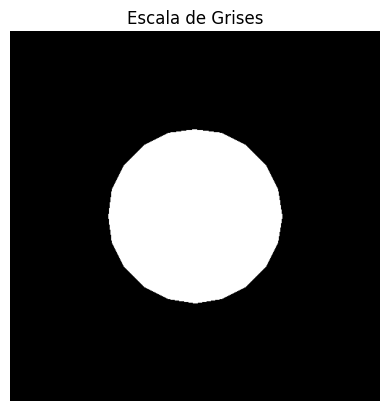

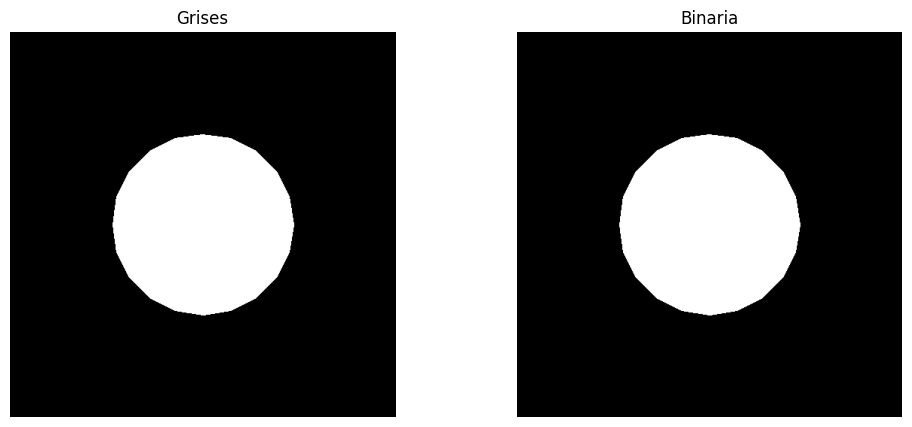

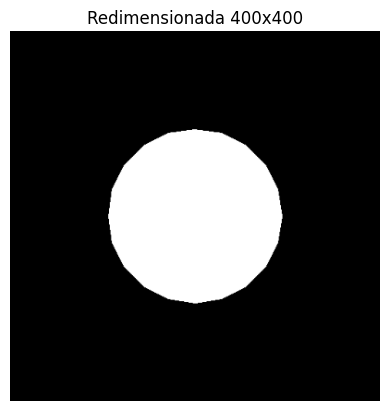

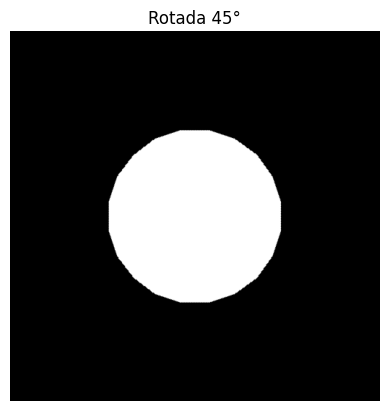

Imagen no encontrada: /content/room-interior-design.jpg. Las operaciones aritméticas se omiten.
Imagen no encontrada: /content/room-interior-design.jpg. Las operaciones lógicas se omiten.


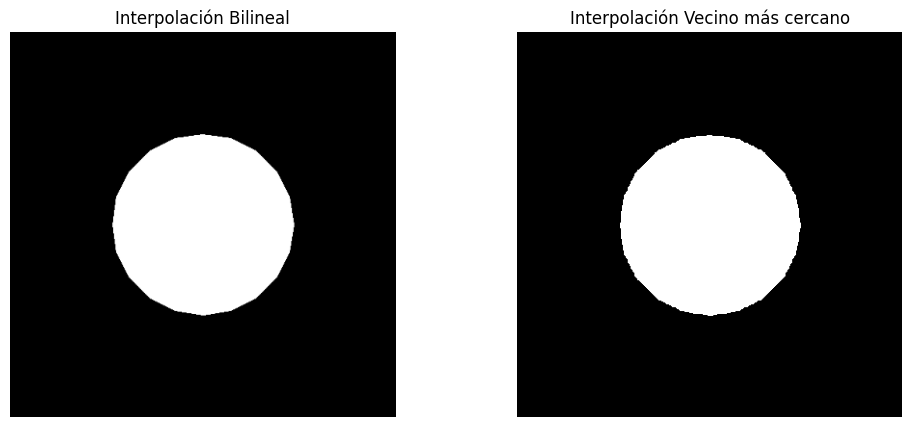

In [24]:
# ================================================
# Procesamiento de Imágenes - Operaciones Básicas
# ================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Funciones de ayuda
# -------------------------------
def mostrar_imagen(img, titulo="Imagen", cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

def mostrar_dos(img1, titulo1, img2, titulo2, cmap1=None, cmap2=None):
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].imshow(img1, cmap=cmap1)
    axes[0].set_title(titulo1)
    axes[0].axis('off')
    axes[1].imshow(img2, cmap=cmap2)
    axes[1].set_title(titulo2)
    axes[1].axis('off')
    plt.show()

# -------------------------------
# 1. RGB → Escala de Grises
# -------------------------------
img = color_bgr  # Usar imagen ya cargada en la notebook
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mostrar_imagen(gray, "Escala de Grises", cmap='gray')

# -------------------------------
# 2. Escala de grises → Binaria
# -------------------------------
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
mostrar_dos(gray, "Grises", binary, "Binaria", 'gray', 'gray')

# -------------------------------
# 3. Cambio de tamaño
# -------------------------------
resized = cv2.resize(img, (400,400))
mostrar_imagen(resized, "Redimensionada 400x400")

# -------------------------------
# 4. Rotación de imagen
# -------------------------------
(h, w) = img.shape[:2]
center = (w//2, h//2)
M = cv2.getRotationMatrix2D(center, 45, 1.0)  # 45 grados
rotated = cv2.warpAffine(img, M, (w, h))
mostrar_imagen(rotated, "Rotada 45°")

# -------------------------------
# 5. Operaciones aritméticas
# -------------------------------
img2_path = '/content/room-interior-design.jpg'
img2 = cv2.imread(img2_path)
if img2 is not None:
    img2 = cv2.resize(img2, (img.shape[1], img.shape[0]))  # Ajustar tamaño

    sum_img = cv2.add(img, img2)
    diff_img = cv2.subtract(img, img2)
    mult_img = cv2.multiply(img, img2)
    div_img = cv2.divide(img, img2)

    fig, axes = plt.subplots(2,2, figsize=(12,8))
    axes[0,0].imshow(sum_img); axes[0,0].set_title("Suma"); axes[0,0].axis('off')
    axes[0,1].imshow(diff_img); axes[0,1].set_title("Resta"); axes[0,1].axis('off')
    axes[1,0].imshow(mult_img); axes[1,0].set_title("Multiplicación"); axes[1,0].axis('off')
    axes[1,1].imshow(div_img); axes[1,1].set_title("División"); axes[1,1].axis('off')
    plt.show()
else:
    print(f"Imagen no encontrada: {img2_path}. Las operaciones aritméticas se omiten.")

# -------------------------------
# 6. Operaciones lógicas
# -------------------------------
_, img1_bin = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
if img2 is not None:
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    _, img2_bin = cv2.threshold(gray2, 128, 255, cv2.THRESH_BINARY)

    and_img = cv2.bitwise_and(img1_bin, img2_bin)
    or_img = cv2.bitwise_or(img1_bin, img2_bin)
    not_img1 = cv2.bitwise_not(img1_bin)
    not_img2 = cv2.bitwise_not(img2_bin)

    fig, axes = plt.subplots(2,2, figsize=(12,8))
    axes[0,0].imshow(and_img, cmap='gray'); axes[0,0].set_title("AND"); axes[0,0].axis('off')
    axes[0,1].imshow(or_img, cmap='gray'); axes[0,1].set_title("OR"); axes[0,1].axis('off')
    axes[1,0].imshow(not_img1, cmap='gray'); axes[1,0].set_title("NOT Imagen 1"); axes[1,0].axis('off')
    axes[1,1].imshow(not_img2, cmap='gray'); axes[1,1].set_title("NOT Imagen 2"); axes[1,1].axis('off')
    plt.show()
else:
    print(f"Imagen no encontrada: {img2_path}. Las operaciones lógicas se omiten.")

# -------------------------------
# 7. Interpolación
# -------------------------------
resized_bilinear = cv2.resize(img, (400,400), interpolation=cv2.INTER_LINEAR)
resized_nearest = cv2.resize(img, (400,400), interpolation=cv2.INTER_NEAREST)

mostrar_dos(resized_bilinear, "Interpolación Bilineal", 
            resized_nearest, "Interpolación Vecino más cercano")


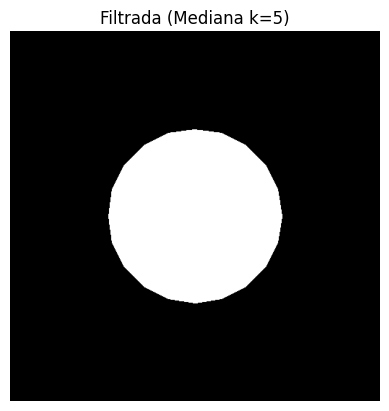

In [25]:
def filtro_median(img, ksize=5):
    """
    Aplica filtro de mediana a una imagen.
    img: imagen numpy array (puede ser gris o color)
    ksize: tamaño del kernel (debe ser impar)
    """
    return cv2.medianBlur(img, ksize)

# Ejemplo de uso sobre la imagen binaria:
img_filtrada = filtro_median(mask_bin, ksize=5)
plt.imshow(img_filtrada, cmap='gray')
plt.title("Filtrada (Mediana k=5)")
plt.axis('off')
plt.show()